In [ ]:
import numpy as np
import pandas as pd
import csv
import pickle
import os
import scipy
import gc
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from keras.utils import np_utils
from keras.layers import LSTM,BatchNormalization
import tensorflow
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# enable gpu
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
DataPath=  '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/RML2016.10b.dat' #'/content/drive/MyDrive/ModulationClassification/RML2016.10b.dat'

In [ ]:
pickle_in = open(DataPath,"rb")
data = pickle.load(pickle_in, encoding="bytes")

In [ ]:
def load_data(data):
  s = np.empty((0,128,2))
  l=np.array([])
  for key in data.keys():
    # load samples
    x,y=key
    x = x.decode('ascii')
    samples = np.array(data.get(key)).transpose(0, 2, 1)
    # create labels
    labels = np.repeat(x+'_'+str(y),samples.shape[0])
    l=np.concatenate([l,labels])
    s=np.vstack((s,samples))
    print('key',key)
    print("samples:",samples.shape)
    print('labels',labels.shape)
  return l,s,data.keys()
  

In [ ]:
def first_drev(data):
  drev = np.empty((0,128,2))
  for i in range(200):
    print(i)
    tmp = np.gradient(data[i*6000:i*6000+6000][:][:],axis=1)
    drev=np.vstack((drev,tmp))
    del tmp
  return drev


In [ ]:
def integral(data):
  data=np.pad(data, [(0, 0),(0,0),(0,1)], 'constant')
  integral = []
  for i in range(200):
    print(i)
    tmp = scipy.integrate.cumtrapz(data[i*6000:i*6000+6000][:][:],dx=1)
    integral.extend(tmp)
    del tmp
    gc.collect()
  return integral

In [ ]:
def split_tuple(labels):
  label, snr = map(list, zip(*(x.split('_') for x in labels)))
  label,snr=np.array(label),np.array(snr)
  return label,snr

In [ ]:
def create_model():
  number_of_channels = 2 
  model = Sequential()
  
  model.add(LSTM(64, input_shape=(128,4)))

  model.add(BatchNormalization())

  model.add(Dense(10, activation ='softmax'))

  
  return model

In [ ]:
# get samples and labels
labels, samples,classes = load_data(data)

In [ ]:
# test drevative
d = np.array(first_drev(samples))
print("drevative:",d.shape)



In [ ]:
# test integration
i = np.array(integral(samples))
print("integral:",i.shape)

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/integral.npy'
samples = np.load(path)
path = '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/labels.npy'
labels= np.load(path)

In [ ]:
# to encode the labels
lb = LabelEncoder()
# split data into train and test
x_train, x_test, y_train, y_test = train_test_split(samples, labels,test_size=0.3, random_state=1 ,stratify=labels)
del samples
del labels
gc.collect()
# take 5% of training set for validation 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train,test_size=0.05, random_state=1,stratify=y_train)

y_train,snr_train = split_tuple(y_train)
y_test,snr_test = split_tuple(y_test)
y_val,snr_val=split_tuple(y_val)

# encode labels
y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_val_lb = np_utils.to_categorical(lb.fit_transform(y_val))
del y_train
del y_val
gc.collect()

0

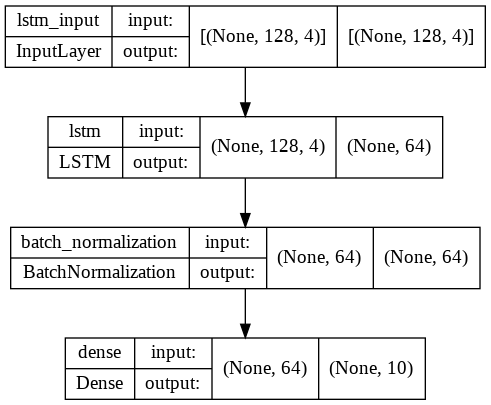

In [ ]:
# create model
model = create_model()
model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam', metrics = ['accuracy'])

# Save an image of the model's architecture to a file
plot_model(model, to_file='Feed Forward NN.png', show_shapes=True, show_layer_names=True)

In [ ]:
#1e-1,1e-2,1e-3,
rates = [1e-4]
epochs = 100
path = '/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/combined/integral/lstm/'
checkpoint_filepath = path+'checkpoint_cnn'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
for lr in rates:
  print("Learning rate:",lr)
  gc.collect()
  model = create_model()
  callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
  opt = tensorflow.keras.optimizers.Adam(learning_rate=lr)
  model.compile(loss = 'categorical_crossentropy',optimizer = opt, metrics = ['accuracy'])

  # train model
  cnn_results = model.fit(x_train, y_train_lb,
                  epochs = epochs,
                  verbose = 1,
                  validation_data = (x_val, y_val_lb),callbacks=[callback,model_checkpoint_callback])
  # Plot model accuracy over ephocs
  plt.plot(cnn_results.history['accuracy'])
  plt.plot(cnn_results.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.savefig(path+f'lr_{str(lr)}.png')
  plt.show()
  print("**************************************************\n\n")


Epoch 1/30
24938/24938 [==============================] - 202s 8ms/step - loss: 1.9297 - accuracy: 0.2413 - val_loss: 1.5964 - val_accuracy: 0.3724
Epoch 2/30
24938/24938 [==============================] - 193s 8ms/step - loss: 1.4289 - accuracy: 0.4283 - val_loss: 1.3441 - val_accuracy: 0.4535
Epoch 3/30
24938/24938 [==============================] - 188s 8ms/step - loss: 1.3134 - accuracy: 0.4673 - val_loss: 1.2678 - val_accuracy: 0.4771
Epoch 4/30
24938/24938 [==============================] - 188s 8ms/step - loss: 1.1756 - accuracy: 0.5167 - val_loss: 1.0924 - val_accuracy: 0.5470
Epoch 5/30
24938/24938 [==============================] - 187s 7ms/step - loss: 1.0699 - accuracy: 0.5527 - val_loss: 1.0391 - val_accuracy: 0.5620
Epoch 6/30
24938/24938 [==============================] - 185s 7ms/step - loss: 1.0366 - accuracy: 0.5668 - val_loss: 1.0283 - val_accuracy: 0.5775
Epoch 7/30
24938/24938 [==============================] - 185s 7ms/step - loss: 1.0078 - accuracy: 0.5883 - val_

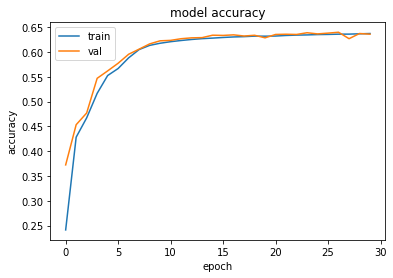

7825

In [ ]:
gc.collect()
model = create_model()
opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss = 'categorical_crossentropy',optimizer = 'Adam', metrics = ['accuracy'])

# train model
cnn_results = model.fit(x_train, y_train_lb,
                  epochs = 30,
                  verbose = 1,
                  validation_data = (x_val, y_val_lb))
# Plot model accuracy over ephocs
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
gc.collect()

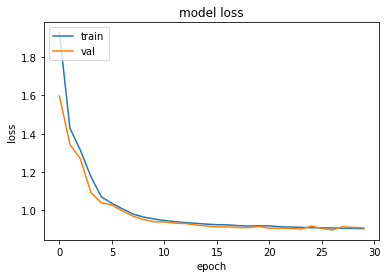

In [ ]:
# Plot model loss over ephocs
plt.plot(cnn_results.history['loss'])
plt.plot(cnn_results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/data/combined/integral/lstm/my_model.h5')

In [ ]:
# train accuracy
score = model.evaluate(x_train, y_train_lb, verbose=0)
print("Training Accuracy: ", score[1])

In [ ]:
del x_train
del y_train_lb
del x_val
del y_val_lb
gc.collect()

3228

In [ ]:
# evaluate test set
# encode labels
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))

score = model.evaluate(x_test, y_test_lb, verbose=0)
print("Testing Accuracy: ", score[1])

Testing Accuracy:  0.6350333094596863


In [ ]:
# to get confusion matrix
y_test_classes = y_test_lb.argmax(1)
y_predicted = model.predict(x_test)
y_pred_classes = np.argmax(y_predicted,axis=1)


In [ ]:
classes = np.load('/content/drive/MyDrive/Colab Notebooks/pattern/lab4/classes.npy')

In [ ]:
# get confusion matrix
confusion_matrix1 = confusion_matrix(y_true= y_test_classes, y_pred=y_pred_classes)
classes = np.array([x[0] for x in classes])
classes=np.unique(classes)
print(classes)
#Add labels to confusion matrix
confusion_matrix1 = pd.DataFrame(confusion_matrix1, columns=list(classes), index=list(classes))

print("The rows represents the true values or observations")
print("The columns respresent the model's predictions")

#Print confusion matrix results
confusion_matrix1

[b'8PSK' b'AM-DSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16' b'QAM64'
 b'QPSK' b'WBFM']
The rows represents the true values or observations
The columns respresent the model's predictions


,b'8PSK',b'AM-DSB',b'BPSK',b'CPFSK',b'GFSK',b'PAM4',b'QAM16',b'QAM64',b'QPSK',b'WBFM'
b'8PSK',19566,725,248,3523,7810,370,694,551,1259,1254
b'AM-DSB',7,25090,38,1085,5067,93,22,5,122,4471
b'BPSK',98,721,21727,2497,7460,1636,115,86,403,1257
b'CPFSK',92,712,123,24986,8100,234,107,95,316,1235
b'GFSK',18,917,62,1553,31578,153,31,15,147,1526
b'PAM4',41,564,698,1860,5392,25984,101,102,296,962
b'QAM16',675,370,206,2771,4782,406,21633,3599,767,791
b'QAM64',528,252,169,2335,3006,360,2772,25451,611,516
b'QPSK',1011,732,243,3569,7641,391,636,362,20229,1186
b'WBFM',13,16119,42,1072,6122,100,26,12,126,12368


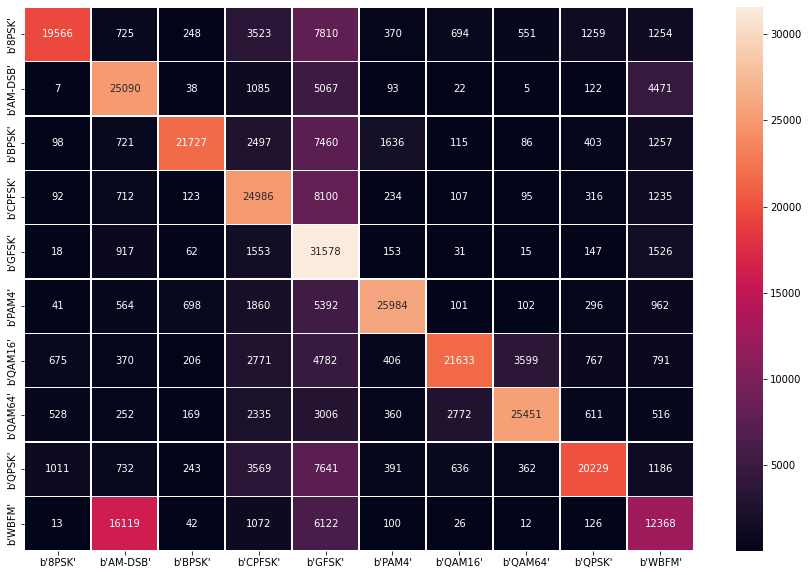

In [ ]:
# get most confusing classes
fig, ax = plt.subplots(figsize=(15,10))         # Sample figsize in inches
sns.heatmap(confusion_matrix1, annot=True, linewidths=.5, ax=ax, fmt='g')

In [ ]:
# Print f1, precision, and recall scores
print("Percision: ",precision_score(y_test_classes, y_pred_classes , average="macro"))
print("Recall: ",recall_score(y_test_classes, y_pred_classes , average="macro"))
print("F-score: ",f1_score(y_test_classes, y_pred_classes , average="macro"))

Percision:  0.7127499655721209
Recall:  0.6350333333333333
F-score:  0.6470836058613552


In [ ]:
# group by snr
snr_test = [int(snr) for snr in snr_test]
sorted_snrs = np.sort(np.unique(snr_test))
x = []
y = []
for snr in sorted_snrs:
  idx = np.where(snr_test == snr)
  x.append(snr)
  y.append(accuracy_score(np.argmax(y_test_lb[idx], axis = 1), np.argmax(y_predicted[idx], axis = 1)))


In [ ]:
# print results of snr
pd.DataFrame(data = np.array(y).reshape(1, -1) * 100,  columns = sorted_snrs, index = ['accuracy']).round(2)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
accuracy,10.5,10.67,11.78,14.74,20.25,30.68,41.28,53.03,69.22,82.94,89.8,91.79,92.34,92.84,92.77,93.16,92.99,93.06,93.05,93.18


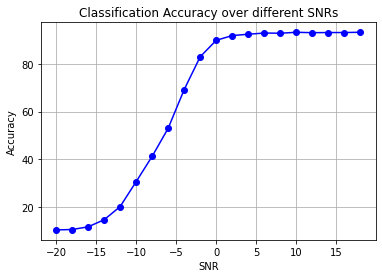

In [ ]:
# plot accuracy vs snr
plt.xlabel('SNR')
plt.ylabel('Accuracy')
plt.title('Classification Accuracy over different SNRs')
plt.plot(x, np.array(y) * 100, 'bo-')
plt.grid(True)